# Exploratory Data Analysis

On the dataset_cleaned_heartless.pkl file

In [1]:
# packages

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path

from collections import Counter
import re
import nltk
from nltk.corpus import stopwords

In [2]:
dataset_heartless_path = Path('../dataset/sa/dataset_cleaned_heartless.pkl').resolve()

dataset = pd.read_pickle(dataset_heartless_path)
# dataset = dataset.sample(frac=p)      # no sampling is needed

# convert the text to string object
dataset['review_text'] = dataset['review_text'].astype('str')

# drop any duplicate just in case
dataset = dataset.drop_duplicates(keep='first')

# replace -1 to 0
# then 0 = negative, 1 = positive
# for easier processing
dataset['review_score'] = dataset['review_score'].replace(-1, 0)

# 4891928 -> 4891746 (some rows have all whitespaces)
dataset['num_of_words'] = dataset['review_text'].apply(lambda x:len(str(x).split()))
dataset = dataset[dataset['num_of_words'] > 0]

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4891746 entries, 0 to 4891927
Data columns (total 7 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   index         int64 
 1   app_id        int64 
 2   app_name      object
 3   review_text   object
 4   review_score  int64 
 5   review_votes  int64 
 6   num_of_words  int64 
dtypes: int64(5), object(2)
memory usage: 298.6+ MB


We will see the ratio between positive and negative reviews

In [3]:
temp = dataset.groupby('review_score').count()['review_text'].reset_index().sort_values(by='review_score',ascending=True)
temp.style.background_gradient(cmap='Purples')

,review_score,review_text
0,0,780949
1,1,4110797


In [4]:
print("Ratio between positive and negative comments: {:.8}".format(
    len(dataset[dataset['review_score'] == 0]) / float(len(dataset[dataset['review_score'] == 1]))
))

Ratio between positive and negative comments: 0.18997508


How about the distribution of length of reviews

In both positive and negative comments respectively

In [5]:
# first have all comments together

dataset['num_of_words'].describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

count    4.891746e+06
mean     6.183327e+01
std      1.077263e+02
min      1.000000e+00
1%       1.000000e+00
10%      5.000000e+00
25%      1.100000e+01
50%      2.600000e+01
75%      6.700000e+01
90%      1.490000e+02
99%      5.370000e+02
max      4.000000e+03
Name: num_of_words, dtype: float64

In [6]:
dataset_pos_only = dataset[dataset['review_score'] == 1]
dataset_neg_only = dataset[dataset['review_score'] == 0]

In [7]:
# describe the characteristics of the number of words

dataset_pos_only['num_of_words'].describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

count    4.110797e+06
mean     5.822571e+01
std      1.030780e+02
min      1.000000e+00
1%       1.000000e+00
10%      5.000000e+00
25%      1.000000e+01
50%      2.400000e+01
75%      6.200000e+01
90%      1.390000e+02
99%      5.120000e+02
max      4.000000e+03
Name: num_of_words, dtype: float64

<Axes: xlabel='num_of_words', ylabel='Count'>

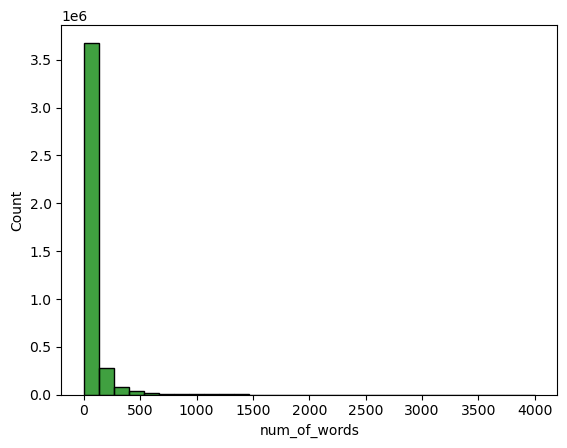

In [8]:
sns.histplot(data=dataset_pos_only, x='num_of_words',bins=30,color='green')

In [9]:
dataset_neg_only['num_of_words'].describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

count    780949.000000
mean         80.822900
std         127.803443
min           1.000000
1%            2.000000
10%           7.000000
25%          15.000000
50%          37.000000
75%          92.000000
90%         195.000000
99%         642.000000
max        1925.000000
Name: num_of_words, dtype: float64

<Axes: xlabel='num_of_words', ylabel='Count'>

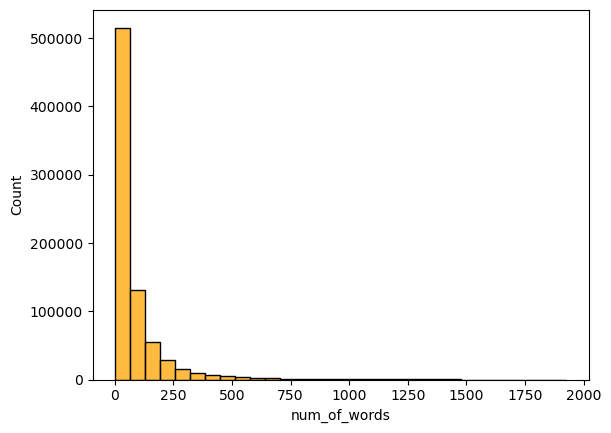

In [10]:
sns.histplot(data=dataset_neg_only, x='num_of_words',bins=30,color='orange')

The public dataset supports the distribution of the comments

- "Negative reviews are slightly longer than positive reviews, but the difference is negligible.". But seems the latter is not supported by the dataset we have.

- "Most games receive reviews with a median length of 205 characters, or 30 words.". The sentence is supported by the positive set and the overall dataset, but not on the negative set.

what if we remove comments less than 10 characters.

In [47]:
dataset_2 = dataset.copy()

number_of_charaters = 20

dataset_2 = dataset_2[dataset_2['review_text'].str.len()>=number_of_charaters]

In [48]:
# first have all comments together

dataset_2['num_of_words'].describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

count    4.626526e+06
mean     6.523254e+01
std      1.098045e+02
min      1.000000e+00
1%       4.000000e+00
10%      7.000000e+00
25%      1.300000e+01
50%      2.900000e+01
75%      7.000000e+01
90%      1.550000e+02
99%      5.490000e+02
max      4.000000e+03
Name: num_of_words, dtype: float64

In [49]:
dataset_2_pos_only = dataset_2[dataset_2['review_score'] == 1]
dataset_2_neg_only = dataset_2[dataset_2['review_score'] == 0]

In [50]:
# describe the characteristics of the number of words

dataset_2_pos_only['num_of_words'].describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

count    3.873162e+06
mean     6.164262e+01
std      1.052375e+02
min      1.000000e+00
1%       4.000000e+00
10%      7.000000e+00
25%      1.200000e+01
50%      2.700000e+01
75%      6.600000e+01
90%      1.450000e+02
99%      5.250000e+02
max      4.000000e+03
Name: num_of_words, dtype: float64

<Axes: xlabel='num_of_words', ylabel='Count'>

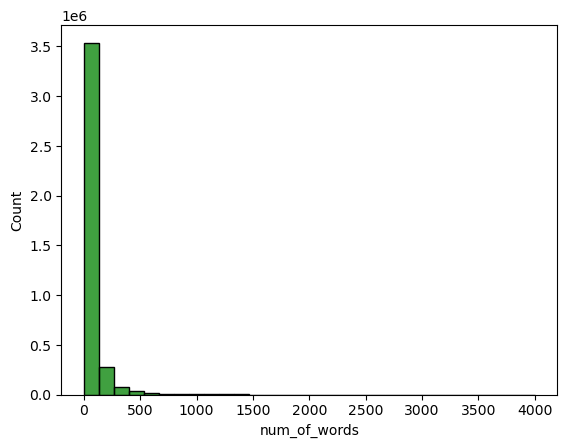

In [37]:
sns.histplot(data=dataset_2_pos_only, x='num_of_words',bins=30,color='green')

In [51]:
dataset_2_neg_only['num_of_words'].describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

count    753364.000000
mean         83.688866
std         129.225425
min           1.000000
1%            4.000000
10%           8.000000
25%          16.000000
50%          40.000000
75%          96.000000
90%         200.000000
99%         651.000000
max        1925.000000
Name: num_of_words, dtype: float64

In [53]:
# select some text for sample

dataset_2_neg_only[dataset_2_neg_only['num_of_words']==645].iloc[0]['review_text']

"After I bought Postal 2, i saw that there was a third one and it had modern-day graphics and i thought that was pretty cool and then I saw all the negative reviews except for the literally only postive review and i thought to myself, hmmm I wonder how bad this game is? Seeing as how the second one was badass and amazingly better than some of the AAA games we get served today, so i bought it, played it and beat it, and now i now why this game is slandered, even RWS has given up on this trainwreck but before i trash this game more i have to say there are parts of this game that are good but far from being awesome.  Like my review of Postal 2, this review will broken down in the same areas  Gameplay, Graphics, Sound and most importantly Story  Warning: this is my opinon and if anything offends you, i deeply apolgize  Gameplay 5/10: the overall gmeplay isn't all to bad, the controls aren't bad but they are a big difference from its predecessor, the main control feature i like about this g

In [54]:
for index, row in dataset_2_pos_only[dataset_2_pos_only['num_of_words'] > 512].sample(n=5).iterrows():
    print("\""+ row['review_text']+ "\",")
    print()

"  Remasters and remakes are nothing new in video games. In fact, it’s been quite the popular trend dating back to the God of War HD collection for the PS3 in 2009. Since then there have been numerous and, one might say, too many remasters and remakes.   If you look at the end of the previous console generation and the beginning of the current, it’s abundantly clear that these have been relied upon far too much.   [en.wikipedia.org]  The criticism of “too many remakes, not enough new IP” is quite fair. That said, very few if any of the remasters/remakes out there show the level of care and reverence that Oddworld: New ‘n’ Tasty exhibits.   My first exposure to the Oddworld series dates back to 1997 and the release of Abe’s Oddysee. Now, while I never played the game I distinctly remember the ads in EGM and Game Pro. Along with Soul Reaver no other game during that time had such striking and wonderful ads. I saw a dingy and strange world that looked unlike anything I had seen before, an

In [55]:
for index, row in dataset_2_neg_only[dataset_2_neg_only['num_of_words'] > 512].sample(n=5).iterrows():
    print("\""+ row['review_text']+ "\",")
    print()

"Edit: Act 2 has been released a while now, but i can safely say I don't feel like going back to this game. It sounds as if I would have to play act 1 all over again just so I can understand stuff in act 2. And Act 2 doesn't sound worth it. So, yeah...  The awkward moment where steam tells you when you purchased the game, rather than when you last played... X(  I bought this game without any prior knowledge of the kickstarter origins of Broken Age, and I feel that this title supports my arguement for NEVER backing a game through kickstarter, unless you like throwing money at something which may never happen. There is always a risk when giving money to someone for something that doesn't exist, and I think a lot of people have unrealistic expectations, and unfortunately in this case, it was the people making the game that didn't plan and budget ahead.  I bought this game in a steam sale not long after it was offically realised, which was the best choice at the time, as I had heard a bit 

<Axes: xlabel='num_of_words', ylabel='Count'>

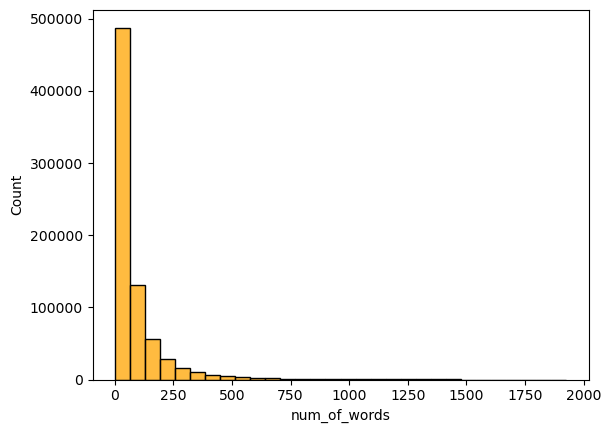

In [56]:
sns.histplot(data=dataset_2_neg_only, x='num_of_words',bins=30,color='orange')

Distribution of words in all review texts

We will perform that with stopwords and w/out stopwords

In [57]:
dataset['list_words'] = dataset['review_text'].apply(lambda x:str(x).split())

In [58]:
top = Counter([item for sublist in dataset['list_words'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,the,11970658
1,and,8062812
2,a,7584539
3,to,7520456
4,of,5805608
5,is,5377929
6,game,5022950
7,I,4888970
8,you,4550865
9,it,3720754


In [59]:
# create a dataset with cleaning performed

dataset_cleaned = dataset.copy(deep=True)

In [60]:
# clean basic characters
def clean(raw):
    """ Remove hyperlinks and markup """
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub("\n", '', result)
    return result

In [61]:
# remove numerics (maybe not required in BERT)
def remove_num(texts):
   output = re.sub(r'\d+', '', texts)
   return output

In [62]:
# remove emojis
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

In [63]:
def unify_whitespaces(x):
    cleaned_string = re.sub(' +', ' ', x)
    return cleaned_string 

In [64]:
# remove special symbols
def remove_symbols(x):
    cleaned_string = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', x)
    return cleaned_string

In [65]:
# remove punctuation (just for analysis, maybe not required in BERT)
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"',','))
    return final

### remove stopwords

Stopwords are words that occur frequently in a language and are often grammatical in nature, such as articles (e.g., "the," "a"), prepositions (e.g., "in," "on"), conjunctions (e.g., "and," "but"), and pronouns (e.g., "he," "she"). These words are necessary for constructing sentences and conveying grammatical structure, but they often do not contribute much to the overall meaning of the text.

- noise reduction
- Improved Analysis Accuracy
- faster processing

In [66]:
from nltk.stem import PorterStemmer
from nltk import WordNetLemmatizer

stop=set(stopwords.words("english"))
stemmer=PorterStemmer()
lemma=WordNetLemmatizer()

def remove_stopword(text):
   text=[word.lower() for word in text.split() if word.lower() not in stop]
   return " ".join(text)

### use stemming to normalize words

Reduce the words to its stem to reduce dimension.
e.g. 

cared ----> care

university ----> univers

fairly ----> fair

easily ----> easili

singing ----> sing

sings ----> sing

sung ----> sung

singer ----> singer

sportingly ----> sport

In [67]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
def stemming(text):
   stem=[]
   # stopword = stopwords.words('english')
   snowball_stemmer = SnowballStemmer('english')
   word_tokens = nltk.word_tokenize(text)
   stemmed_word = [snowball_stemmer.stem(word) for word in word_tokens]
   stem=' '.join(stemmed_word)
   return stem

In [68]:
def cleaning(df,review):
    df[review] = df[review].apply(clean)
    df[review] = df[review].apply(deEmojify)
    df[review] = df[review].str.lower()
    df[review] = df[review].apply(remove_num)
    df[review] = df[review].apply(remove_symbols)
    df[review] = df[review].apply(remove_punctuation)
    df[review] = df[review].apply(remove_stopword)
    df[review] = df[review].apply(unify_whitespaces)
    df[review] = df[review].apply(stemming)

In [69]:
cleaning(dataset_cleaned,'review_text')

In [70]:
dataset_cleaned['list_words'] = dataset_cleaned['review_text'].apply(lambda x:str(x).split())

In [73]:
top2 = Counter([item for sublist in dataset_cleaned['list_words'] for item in sublist])
temp2 = pd.DataFrame(top2.most_common(20))
temp2.columns = ['Common_words','count']
temp2.style.background_gradient(cmap='Blues')

,Common_words,count
0,game,8396572
1,play,2441601
2,like,1686181
3,get,1411174
4,one,1191743
5,good,1174170
6,fun,1128581
7,time,1120780
8,great,1015484
9,realli,973986


<Axes: xlabel='count', ylabel='Common_words'>

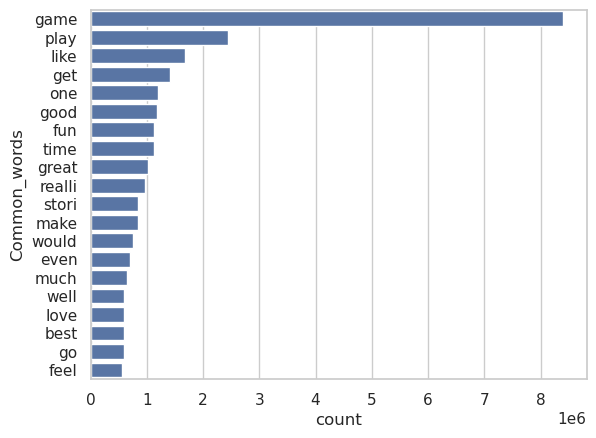

In [74]:
sns.set_theme(style="whitegrid")
sns.barplot(x="count", y="Common_words", data=temp2)

In [91]:
len(Counter({k:c for k,c in top2.items() if c >= 1000}))

6420

In [80]:
# find top 5000 ?

top2.most_common(7000)[-30:]

[('transcend', 837),
 ('tout', 837),
 ('gateway', 837),
 ('swedish', 837),
 ('python', 836),
 ('mentor', 836),
 ('optimist', 836),
 ('ritual', 836),
 ('intervent', 835),
 ('buffer', 835),
 ('herb', 835),
 ('literali', 834),
 ('approx', 834),
 ('vergil', 834),
 ('pr', 833),
 ('copyright', 833),
 ('undetect', 833),
 ('coal', 833),
 ('wand', 833),
 ('ctf', 832),
 ('pase', 832),
 ('gunshot', 832),
 ('perceiv', 832),
 ('pov', 832),
 ('louder', 832),
 ('eido', 832),
 ('bun', 831),
 ('whop', 831),
 ('intersect', 831),
 ('cloaker', 831)]

If we break into positive and negative comments...

In [56]:
dataset_cleaned_pos_only = dataset_cleaned[dataset_cleaned['review_score'] == 1]
dataset_cleaned_neg_only = dataset_cleaned[dataset_cleaned['review_score'] == 0]

In [57]:
top3 = Counter([item for sublist in dataset_cleaned_pos_only['list_words'] for item in sublist])
temp3 = pd.DataFrame(top3.most_common(20))
temp3.columns = ['Common_words','count']
temp3.style.background_gradient(cmap='Blues')

,Common_words,count
0,game,6786797
1,play,2007689
2,like,1349577
3,get,1096717
4,good,998402
5,fun,997776
6,one,990678
7,great,932459
8,time,883272
9,realli,783901


<Axes: xlabel='count', ylabel='Common_words'>

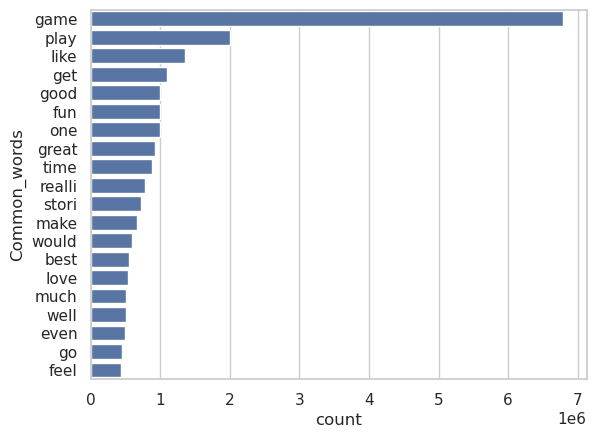

In [58]:
sns.set_theme(style="whitegrid")
sns.barplot(x="count", y="Common_words", data=temp3)

In [59]:
top4 = Counter([item for sublist in dataset_cleaned_neg_only['list_words'] for item in sublist])
temp4 = pd.DataFrame(top4.most_common(20))
temp4.columns = ['Common_words','count']
temp4.style.background_gradient(cmap='Blues')

,Common_words,count
0,game,1609775
1,play,433912
2,like,336604
3,get,314457
4,time,237508
5,even,206462
6,one,201065
7,realli,190085
8,good,175768
9,make,172682


<Axes: xlabel='count', ylabel='Common_words'>

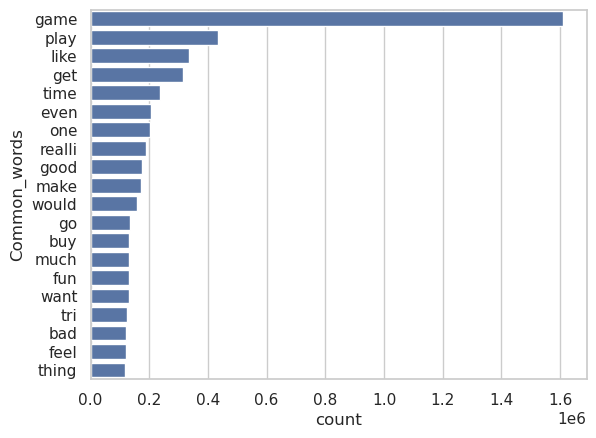

In [60]:
sns.set_theme(style="whitegrid")
sns.barplot(x="count", y="Common_words", data=temp4)

what are the common words appeared in both top 20?

In [61]:
temp5 = pd.merge(temp3,temp4, how='inner', on=['Common_words'])

In [62]:
temp5

,Common_words,count_x,count_y
0,game,6786797,1609775
1,play,2007689,433912
2,like,1349577,336604
3,get,1096717,314457
4,good,998402,175768
5,fun,997776,130805
6,one,990678,201065
7,time,883272,237508
8,realli,783901,190085
9,make,662683,172682


looks almost the same as the overall dataset, as the positive comments are very domainant...

Due to hardware limitation, we will create a balanced dataset by randomly sampling positive comments in training

There are different methods in randomly selecting samples, yet the difference in performance are not significant (~0.01 in accuracy)  
E.g.: https://ruslanmv.com/blog/How-to-handle-imbalanced-text-data-in-Natural-Language-Processing

The undersampler in imbalanced-learning package will be applied on the training set

Then we may scrap new comments for validation on recent comments :D